## Lab: RNN with Forecasting

### Wind Turbine Power Prediction with RNN

This lab uses a Recurrent Neural Network to predict wind turbine power output.
* [Data link](https://www.kaggle.com/code/ahmedfathygwely/wind-turbine-dataset-machine-learning-rnn-times/input)

### Step 0: Load libraries & Data

In [16]:
# Step 0: Load libraries & Data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import math

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load the data
df = pd.read_csv('T1.csv')

In [5]:
# Display basic information
print(df.shape)
print(df.info())
print(df.describe())
print(df.head())
print(df.isna().sum())

(50530, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50530 entries, 0 to 50529
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Date/Time                      50530 non-null  object 
 1   LV ActivePower (kW)            50530 non-null  float64
 2   Wind Speed (m/s)               50530 non-null  float64
 3   Theoretical_Power_Curve (KWh)  50530 non-null  float64
 4   Wind Direction (°)             50530 non-null  float64
dtypes: float64(4), object(1)
memory usage: 1.9+ MB
None
       LV ActivePower (kW)  Wind Speed (m/s)  Theoretical_Power_Curve (KWh)  \
count         50530.000000      50530.000000                   50530.000000   
mean           1307.684332          7.557952                    1492.175463   
std            1312.459242          4.227166                    1368.018238   
min              -2.471405          0.000000                       0.000000   
25%      

### Step 1: Prepare the data

In [7]:
# Step 1: Prepare the data
df['Date/Time'] = pd.to_datetime(df['Date/Time'], dayfirst=True)
df.set_index('Date/Time', inplace=True)
df.sort_index(inplace=True)

# Feature engineering
df['wind_dir_sin'] = np.sin(np.radians(df['Wind Direction (°)']))
df['wind_dir_cos'] = np.cos(np.radians(df['Wind Direction (°)']))
df.drop(columns=['Wind Direction (°)', 'Theoretical_Power_Curve (KWh)'], inplace=True)

target = 'LV ActivePower (kW)'
features = [col for col in df.columns if col != target]

print(f"\nFeatures: {features}")
print(f"Target: {target}")
print(f"\nFinal shape: {df.shape}")


Features: ['Wind Speed (m/s)', 'wind_dir_sin', 'wind_dir_cos']
Target: LV ActivePower (kW)

Final shape: (50530, 4)


### Wind direction → sin/cos decomposition
Wind direction is circular: 359° and 1° are almost identical, but numerically they're 358 apart. If you feed raw degrees into the model, it thinks those two directions are maximally different. Decomposing into sin and cos maps the circle onto two continuous values where nearby angles have nearby values:

### Why drop Theoretical_Power_Curve?
It's basically the answer key. Including it would inflate your metrics without the model learning real patterns.

If you include it, the RNN mostly just learns "copy this column" and your R² looks amazing but the model hasn't learned anything meaningful. Dropping it forces the model to learn the actual relationship between wind conditions and power output, which is the whole point.

### Step 2: Create sequences

In [9]:
# Step 2: Create sequences

# Scale all columns together
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# Define sequence length
seq_size = 24

X = []
y = []
for i in range(seq_size, len(scaled_data)):
    X.append(scaled_data[i-seq_size:i])       # all features for the window
    y.append(scaled_data[i, 0])                # target is first column (LV ActivePower)

X = np.array(X)
y = np.array(y)

print(f"X shape: {X.shape}")   # (samples, 24, n_features)
print(f"y shape: {y.shape}")   # (samples,)

X shape: (50506, 24, 4)
y shape: (50506,)


In [10]:
print(df.columns.tolist())

['LV ActivePower (kW)', 'Wind Speed (m/s)', 'wind_dir_sin', 'wind_dir_cos']


### Step 3: Split the data

In [11]:
# Step 3: Split the data
split = int(len(X) * 0.8)

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test:  {X_test.shape}, y_test:  {y_test.shape}")

X_train: (40404, 24, 4), y_train: (40404,)
X_test:  (10102, 24, 4), y_test:  (10102,)


train_test_split shuffles by default, which breaks time series data.

### Step 4: Build the RNN Model

In [17]:
# Step 4: Build the RNN Model
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 24, 64)         │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,113 (117.63 KB)

 Trainable params: 30,113 (117.63 KB)

 Non-trainable params: 0 (0.00 B)

First LSTM(64, return_sequences=True) — 64 units, and return_sequences=True because we're stacking a second LSTM layer after it. It needs to pass the full sequence forward, not just the last time step.
Second LSTM(32) — return_sequences defaults to False, so it only outputs the final time step — condensing the sequence into a single vector for prediction.
Dropout(0.2) — After each LSTM, drops 20% of connections randomly during training to prevent overfitting.
Dense(1) — Single output neuron for our power prediction.
input_shape=(X_train.shape[1], X_train.shape[2]) — This is (seq_size, n_features), telling the model the shape of each input sequence.

### Step 5: Train the model

In [18]:
# Step 5: Train the model

history = model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=1)

Epoch 1/100
2526/2526 ━━━━━━━━━━━━━━━━━━━━ 49s 18ms/step - loss: 0.0115 - mae: 0.0698
Epoch 2/100
2526/2526 ━━━━━━━━━━━━━━━━━━━━ 49s 19ms/step - loss: 0.0068 - mae: 0.0542
Epoch 3/100
2526/2526 ━━━━━━━━━━━━━━━━━━━━ 48s 19ms/step - loss: 0.0064 - mae: 0.0529
Epoch 4/100
2526/2526 ━━━━━━━━━━━━━━━━━━━━ 51s 20ms/step - loss: 0.0061 - mae: 0.0525
Epoch 5/100
2526/2526 ━━━━━━━━━━━━━━━━━━━━ 48s 19ms/step - loss: 0.0061 - mae: 0.0523
Epoch 6/100
2526/2526 ━━━━━━━━━━━━━━━━━━━━ 47s 19ms/step - loss: 0.0060 - mae: 0.0520
Epoch 7/100
2526/2526 ━━━━━━━━━━━━━━━━━━━━ 47s 18ms/step - loss: 0.0060 - mae: 0.0517
Epoch 8/100
2526/2526 ━━━━━━━━━━━━━━━━━━━━ 46s 18ms/step - loss: 0.0060 - mae: 0.0518
Epoch 9/100
2526/2526 ━━━━━━━━━━━━━━━━━━━━ 47s 19ms/step - loss: 0.0060 - mae: 0.0516
Epoch 10/100
2526/2526 ━━━━━━━━━━━━━━━━━━━━ 46s 18ms/step - loss: 0.0059 - mae: 0.0513
Epoch 11/100
2526/2526 ━━━━━━━━━━━━━━━━━━━━ 44s 17ms/step - loss: 0.0059 - mae: 0.0513
Epoch 12/100
2526/2526 ━━━━━━━━━━━━━━━━━━━━ 43s 17ms

### Step 6: Evaluate on the test data and visualize the results

316/316 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
RMSE: 232.05 kW
R²:   0.9701


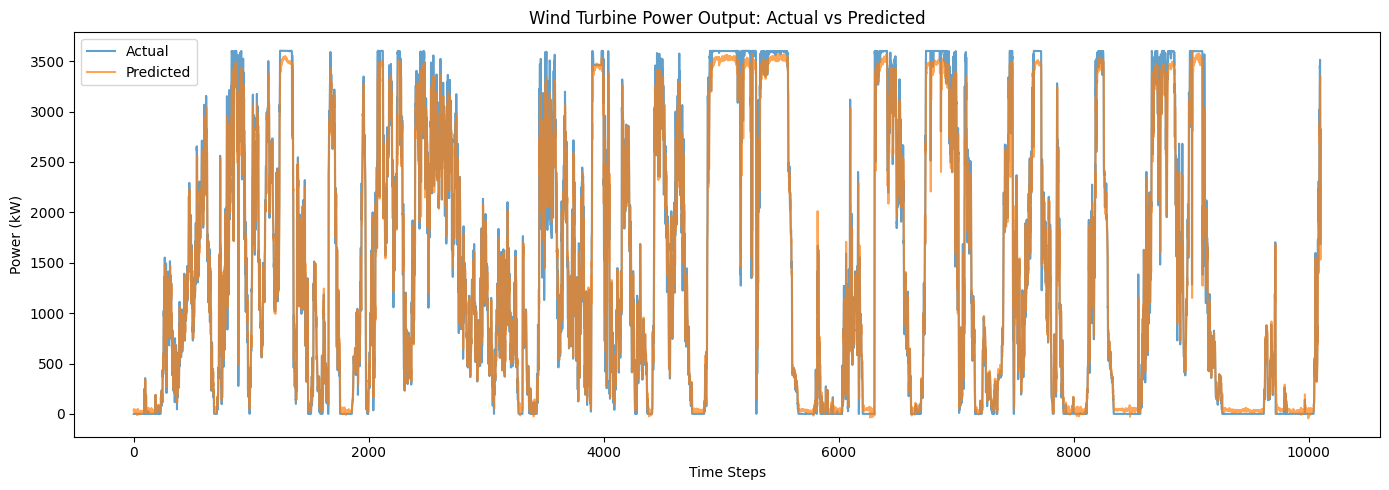

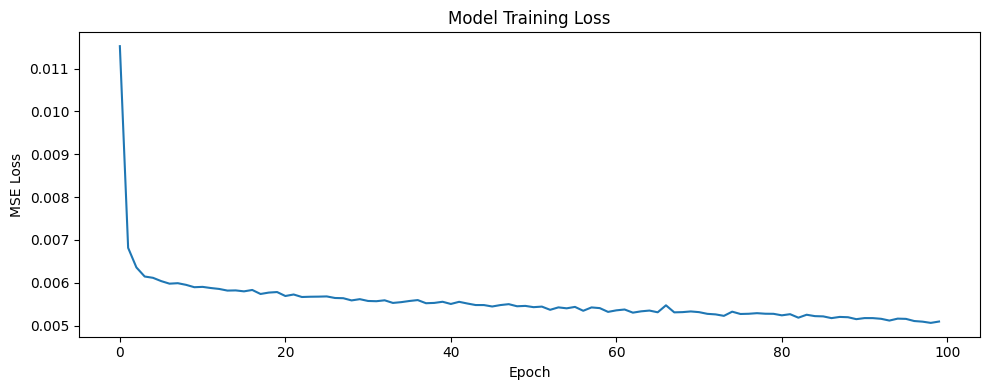

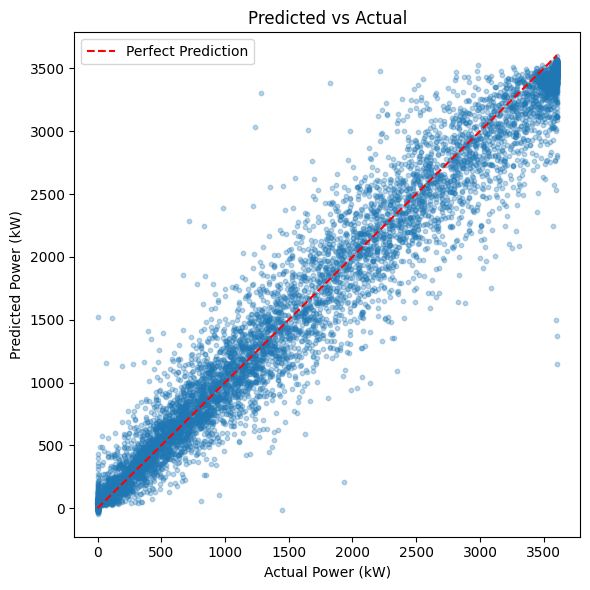

In [19]:

# Make predictions
y_pred = model.predict(X_test)

# Inverse transform to get back to original scale
# We need to create dummy arrays since scaler was fit on all columns
dummy_pred = np.zeros((len(y_pred), scaled_data.shape[1]))
dummy_pred[:, 0] = y_pred.flatten()
y_pred_actual = scaler.inverse_transform(dummy_pred)[:, 0]

dummy_test = np.zeros((len(y_test), scaled_data.shape[1]))
dummy_test[:, 0] = y_test.flatten()
y_test_actual = scaler.inverse_transform(dummy_test)[:, 0]

# Metrics
rmse = math.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
r2 = r2_score(y_test_actual, y_pred_actual)
print(f"RMSE: {rmse:.2f} kW")
print(f"R²:   {r2:.4f}")

# ---- Plot 1: Actual vs Predicted ----
plt.figure(figsize=(14, 5))
plt.plot(y_test_actual, label='Actual', alpha=0.7)
plt.plot(y_pred_actual, label='Predicted', alpha=0.7)
plt.title('Wind Turbine Power Output: Actual vs Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Power (kW)')
plt.legend()
plt.tight_layout()
plt.show()

# ---- Plot 2: Training Loss ----
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'])
plt.title('Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.tight_layout()
plt.show()

# ---- Plot 3: Scatter Plot ----
plt.figure(figsize=(6, 6))
plt.scatter(y_test_actual, y_pred_actual, alpha=0.3, s=10)
plt.plot([0, max(y_test_actual)], [0, max(y_test_actual)], 'r--', label='Perfect Prediction')
plt.title('Predicted vs Actual')
plt.xlabel('Actual Power (kW)')
plt.ylabel('Predicted Power (kW)')
plt.legend()
plt.tight_layout()
plt.show()